In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
datasets = [
    {
        "name": "Heart Attack Prediction Dataset",
        "path": r"C:\Users\arpitha_work\Downloads\TRU MSCDS\DS Seminar Project\Heart attack analysis & prediction dataset\heart.csv",
        "features_numerical": ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak'],
        "features_categorical": ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'],
        "target": "output",
    },

    {
        "name": "Heart Failure Prediction",
        "path": r"C:\Users\arpitha_work\Downloads\TRU MSCDS\DS Seminar Project\Heat Failure Prediction Dataset\heart.csv",
        "features_numerical": ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak' ],
        "features_categorical": ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'],
        "target": "HeartDisease",
    },

    {
        "name": "Heart Failure Prediction 2",
        "path": r"C:\Users\arpitha_work\Downloads\TRU MSCDS\DS Seminar Project\Heart Failure Prediction Dataset 2\heart_failure_clinical_records_dataset.csv",
        "features_numerical": ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time' ],
        "features_categorical": ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking',],
        "target": "DEATH_EVENT",
    },

    {
        "name": "Cardiovascular Disease Dataset",
        "path": r"C:\Users\arpitha_work\Downloads\TRU MSCDS\DS Seminar Project\Cardiovascular Disease Dataset\cardio_train.csv",
        "features_numerical": ['age', 'height', 'weight', 'ap_hi', 'ap_lo' ],
        "features_categorical": ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'],
        "target": "cardio",
    },

    {
        "name": "Indicators of Heart Disease",
        "path": r"C:\Users\arpitha_work\Downloads\TRU MSCDS\DS Seminar Project\Indicators of Heart Disease\2020\heart_2020_cleaned.csv",
        "features_numerical": ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',  ],
        "features_categorical": ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer', ],
        "target": "HeartDisease",
    },

]


In [3]:
def preprocess_dataset(dataset):
    print(f"Processing dataset: {dataset['name']}")
    df = pd.read_csv(dataset['path'])
    X_num = df[dataset["features_numerical"]]
    X_cat = df[dataset["features_categorical"]]
    y = df[dataset["target"]]

    # Encode categorical variables
    X_cat = pd.get_dummies(X_cat, drop_first=True)
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Combine features
    X = pd.concat([X_num, X_cat], axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train.iloc[:, :len(dataset["features_numerical"])] = scaler.fit_transform(X_train.iloc[:, :len(dataset["features_numerical"])])
    X_test.iloc[:, :len(dataset["features_numerical"])] = scaler.transform(X_test.iloc[:, :len(dataset["features_numerical"])])

    return X_train.to_numpy(), X_test.to_numpy(), y_train, y_test


In [4]:
def train_models(X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=5)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

    knn.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    return knn, gb


In [5]:
# Store evaluation results
evaluation_results = []

# Main processing loop
for dataset in datasets:
    X_train, X_test, y_train, y_test = preprocess_dataset(dataset)
    knn, gb = train_models(X_train, y_train)

    # Evaluate models
    knn_probs = knn.predict_proba(X_test)[:, 1]
    gb_probs = gb.predict_proba(X_test)[:, 1]
    fused_probs = 0.3 * knn_probs + 0.7 * gb_probs
    y_pred_fused = (fused_probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_fused)
    roc_auc = roc_auc_score(y_test, fused_probs)

    print(f"{dataset['name']} - Accuracy: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")
    evaluation_results.append({
        "dataset": dataset["name"],
        "accuracy": acc,
        "roc_auc": roc_auc,
        "fpr": roc_curve(y_test, fused_probs)[0],
        "tpr": roc_curve(y_test, fused_probs)[1],
    })


Processing dataset: Heart Attack Prediction Dataset
Heart Attack Prediction Dataset - Accuracy: 0.8022, ROC-AUC: 0.8839
Processing dataset: Heart Failure Prediction
Heart Failure Prediction - Accuracy: 0.8659, ROC-AUC: 0.9393
Processing dataset: Heart Failure Prediction 2
Heart Failure Prediction 2 - Accuracy: 0.7111, ROC-AUC: 0.8404
Processing dataset: Cardiovascular Disease Dataset
Cardiovascular Disease Dataset - Accuracy: 0.7332, ROC-AUC: 0.7951
Processing dataset: Indicators of Heart Disease
Indicators of Heart Disease - Accuracy: 0.9147, ROC-AUC: 0.8261


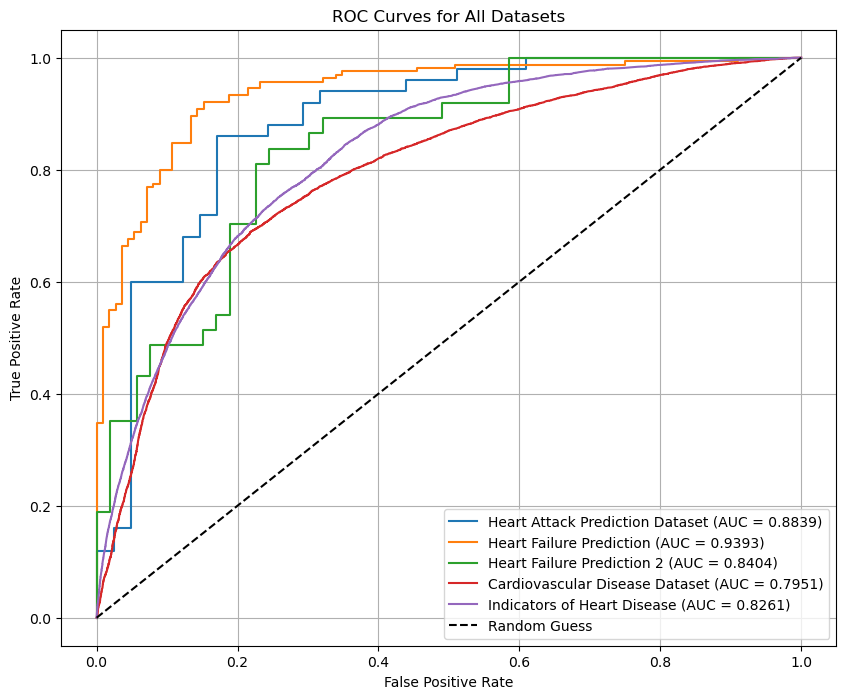

In [6]:
plt.figure(figsize=(10, 8))
for result in evaluation_results:
    plt.plot(result["fpr"], result["tpr"], label=f'{result["dataset"]} (AUC = {result["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves for All Datasets")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


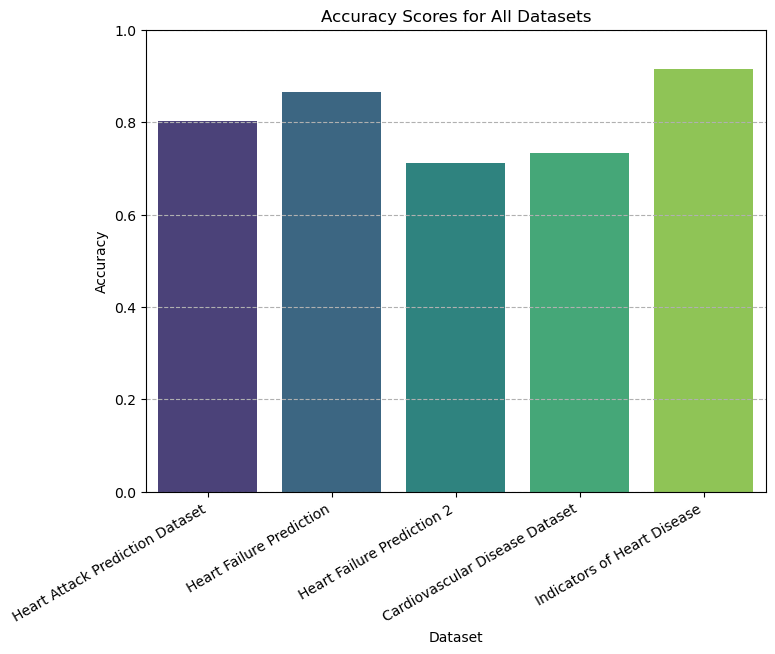

In [7]:
plt.figure(figsize=(8, 6))
accuracy_data = pd.DataFrame(evaluation_results)
sns.barplot(x="dataset", y="accuracy", data=accuracy_data, palette="viridis")
plt.ylim(0, 1)
plt.title("Accuracy Scores for All Datasets")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.xticks(rotation=30, ha="right")
plt.grid(axis='y', linestyle='--')
plt.show()
